In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scienceplots

from scipy import stats as st
from scipy.ndimage import gaussian_filter1d

from CML_tool.ML_Utils import compute_empirical_ci
from CML_tool.FancyShapPlots import fit_univariate_spline


plt.style.use(['science'])

# Fit a Unvariate spline to some non-linear function

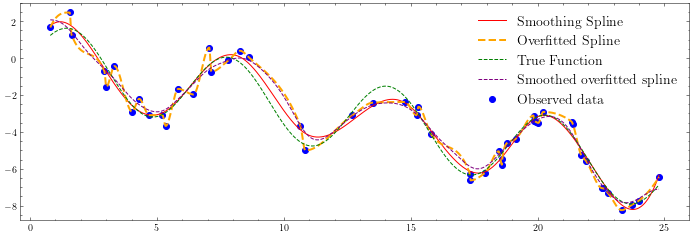

In [2]:
plt.figure(figsize=(12, 4))
# Generate time points
# x = np.linspace(0,5*np.pi, 100) # Gives equally spaced data on X
x = np.sort(np.random.rand(50) * 8 * np.pi) # Randomly spaced data on X

# Create a sinusoidal signal with random noise
y = 2*np.sin(x)- 0.25*x + 0.5 * np.random.normal(size=len(x))

# Fit a univariate spline to the data
spline, x_pred, y_pred = fit_univariate_spline(x, y, s=10, k=3, resolution=1000, spline='smoothing')
spline_monotonic, x_data, y_pred_mono = fit_univariate_spline(x, y, s=10, k=3, resolution=1000, spline='overfitted')

# Plot the original data and the fitted spline
plt.scatter(x, y, label='Observed data', color='blue')
plt.plot(x_pred, y_pred, label='Smoothing Spline', color='red')
plt.plot(x_pred, y_pred_mono, label='Overfitted Spline', color='orange', linestyle='--', linewidth=2)
plt.plot(x_pred, 2*np.sin(x_pred)- 0.25*x_pred, label='True Function', color='green', linestyle='--')
plt.plot(x_pred, gaussian_filter1d(y_pred_mono, 20), label='Smoothed overfitted spline', color='purple', linestyle='--')


plt.legend(fontsize=14)
plt.show()

# Get empirical confidence intervals in the fitting

### Bootstrap confidence intervals

In [3]:
n_boot = 5000
idx_boot = np.sort(np.random.choice(len(x), size= (n_boot,len(x)), replace=True))
data_boot = [(x[idx], y[idx]) for idx in idx_boot]

# Overfitted 
X_splines = np.vstack([fit_univariate_spline(x, y, s=10, k=3,resolution=1000, spline='overfitted')[2] for (x,y) in data_boot])
X_splines_over = X_splines[~np.isnan(X_splines).any(axis=1)] # drop rows with NaN values
low_over, upper_over = zip(*compute_empirical_ci(
    X=X_splines_over,
    alpha=0.05,
    type='quantile'
))

# Smooth
X_splines_smooth = np.vstack([fit_univariate_spline(x, y, s=10, k=3,resolution=1000, spline='smoothing')[2] for (x,y) in data_boot])
X_splines_smooth = X_splines_smooth[~np.isnan(X_splines_smooth).any(axis=1)] # drop rows with NaN values
low_smooth, upper_smooth = zip(*compute_empirical_ci(
    X=X_splines_smooth,
    alpha=0.05,
    type='quantile'
))

/Users/barbem4/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


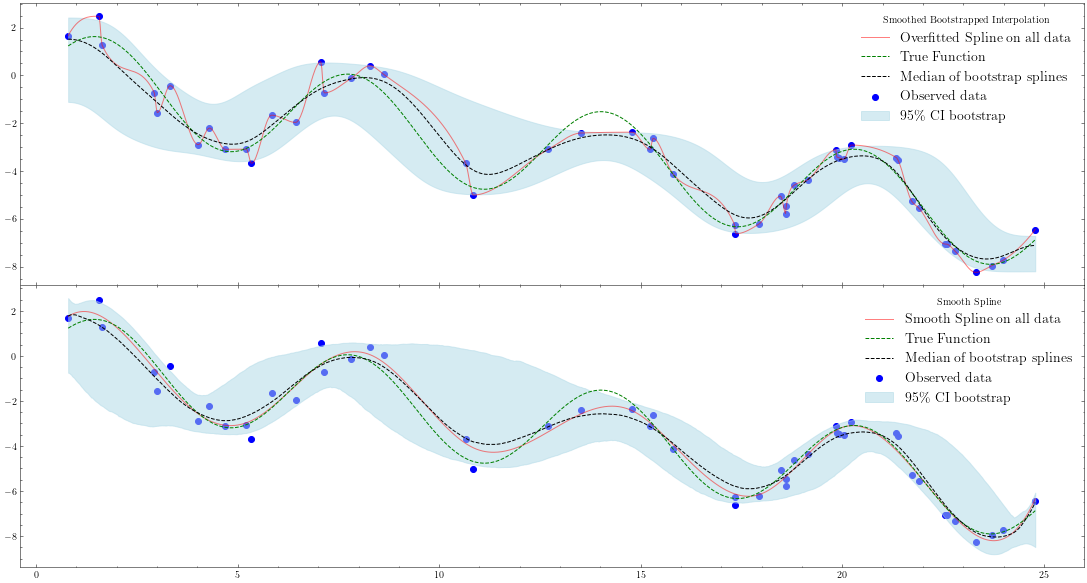

In [4]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)

# Smooth overfitted arrays
sigma=20
low_over_smooth = gaussian_filter1d(low_over, sigma)
upper_over_smooth = gaussian_filter1d(upper_over, sigma)
smoothed_median = gaussian_filter1d(np.median(X_splines_over, axis=0), sigma)

# Plot the original data and the fitted spline
ax1.scatter(x, y, label='Observed data', color='blue')
ax1.plot(x_pred, y_pred_mono, label='Overfitted Spline on all data', color='red', alpha = 0.5)
ax1.plot(x_pred, 2*np.sin(x_pred)- 0.25*x_pred, label='True Function', color='green', linestyle='--')
ax1.fill_between(x_pred, low_over_smooth, upper_over_smooth, color='lightblue', alpha=0.5, label='95\% CI bootstrap')
ax1.plot(x_pred, smoothed_median, color='black', label='Median of bootstrap splines', linestyle='--')
# ax1.plot(x_pred, np.mean(X_splines_over, axis=0), color='purple', label='Mean of bootstrap splines', linestyle='-.', linewidth=2, alpha=.5)

ax1.legend(fontsize=14, title='Smoothed Bootstrapped Interpolation', loc='upper right')


ax2.scatter(x, y, label='Observed data', color='blue')
ax2.plot(x_pred, y_pred, label='Smooth Spline on all data', color='red', alpha = 0.5)
ax2.plot(x_pred, 2*np.sin(x_pred)- 0.25*x_pred, label='True Function', color='green', linestyle='--')
ax2.fill_between(x_pred, low_smooth, upper_smooth, color='lightblue', alpha=0.5, label='95\% CI bootstrap')
ax2.plot(x_pred, np.median(X_splines_smooth, axis=0), color='black', label='Median of bootstrap splines', linestyle='--')
# ax2.plot(x_pred, np.mean(X_splines_smooth, axis=0), color='purple', label='Mean of bootstrap splines', linestyle='-.', linewidth=2, alpha=.5)


# plt.ylim([-5,5])

plt.tight_layout(pad=0)
ax2.legend(fontsize=14, title='Smooth Spline', loc='upper right')
plt.show()

### Prediction error confidence errors

In [5]:
# Sort the data
sorted_idx = np.argsort(x)
x_sorted = x[sorted_idx]
y_sorted = y[sorted_idx]
non_nan = ~np.isnan(x_sorted) & ~np.isnan(y_sorted)

# Compute confidence intervals
residuals = y_sorted[non_nan] - spline(x_sorted[non_nan])
sigma = np.std(residuals)
ci = st.norm.ppf(1-0.05) * sigma  # 95% confidence interval
low_ci_lim, upper_ci_lim = y_pred - ci, y_pred + ci

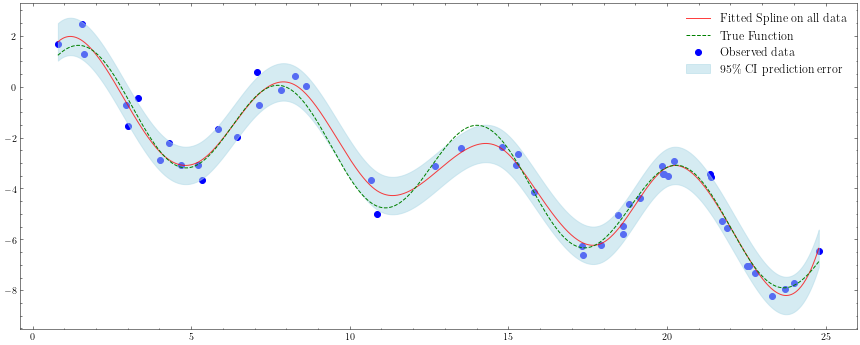

In [6]:
plt.figure(figsize=(15, 6))

# Plot the original data and the fitted spline
plt.scatter(x, y, label='Observed data', color='blue')
plt.plot(x_pred, y_pred, label='Fitted Spline on all data', color='red', alpha = 0.75)
plt.plot(x_pred, 2*np.sin(x_pred)- 0.25*x_pred, label='True Function', color='green', linestyle='--')
plt.fill_between(x_pred, low_ci_lim, upper_ci_lim, color='lightblue', alpha=0.5, label='95\% CI prediction error')

plt.legend(fontsize=12)
plt.show()

# Fancy SHAP scatter plot

In [7]:
import shap

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from CML_tool.FancyShapPlots import scatter_plot

In [8]:
# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Convert to a binary classification problem (class 0 vs. all others)
y_binary = (y == 0).astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [9]:
# Create and train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy (binary) on Iris dataset:", accuracy)

Random Forest accuracy (binary) on Iris dataset: 1.0


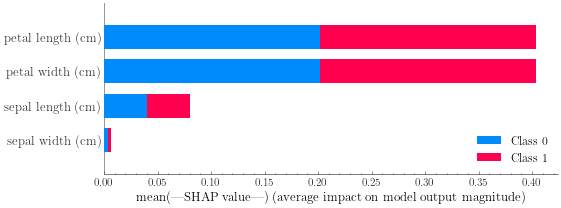

In [10]:
# Initialize the SHAP TreeExplainer on the trained random forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(X_test)

# Plot a quick summary bar chart of feature importance
shap.summary_plot(shap_values, X_test, feature_names=iris.feature_names, plot_type="bar")

In [11]:
# Get the explanation object for the first instance in the test set
explanation = explainer(X_test)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='$P(X)$: sepal length (cm)', ylabel='$P(Y|X): $ Shapley value'>)

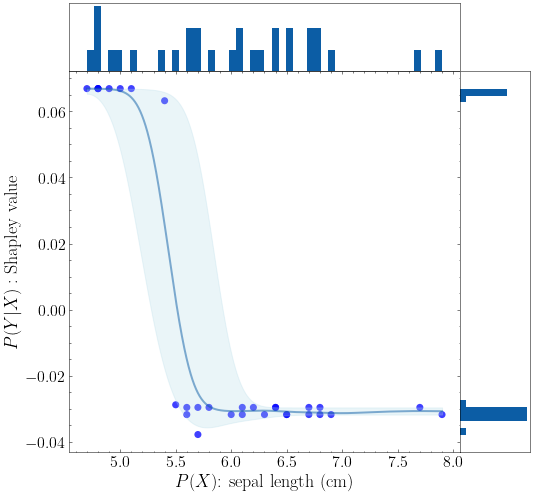

In [12]:
scatter_plot(
    explanation=explanation,
    feature_names=iris.feature_names,
    feature_idx=0,
    show_scatter=True,
    alpha=0.75,
    show_reg=True,
    spline_type='overfitted',
    sigma=50,
    s=0.1,
    k=3,
    resolution=1000,
    show_ci=True,
    significant_level=0.05,
    ci_type='bootstrap',
    n_bootstrap=1000,
    show_hist=True,
    hist_bins=50,
    marker_size=50  
)

(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='$P(X)$: sepal length (cm)', ylabel='$P(Y|X): $ Shapley value'>)

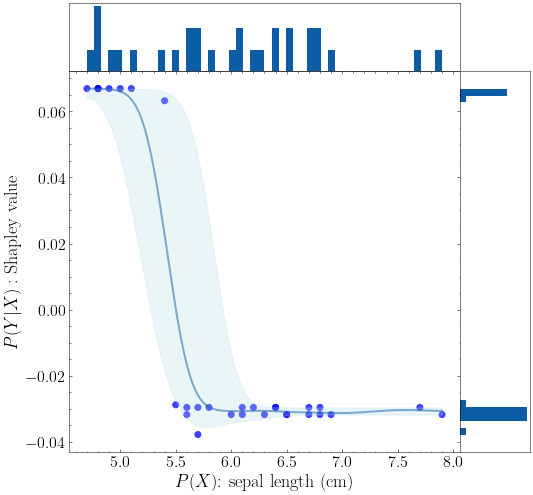

In [13]:
scatter_plot(
    explanation=explanation,
    feature_names=iris.feature_names,
    feature_idx=0,
    show_scatter=True,
    alpha=0.75,
    show_reg=True,
    spline_type='overfitted',
    sigma=50,
    s=0.1,
    k=3,
    resolution=1000,
    show_ci=True,
    significant_level=0.05,
    ci_type='bootstrap',
    n_bootstrap=1000,
    show_hist=True,
    hist_bins=50,
    marker_size=50  
)